# 3章　傾向スコアを用いた分析

## マッチング

In [40]:
import pandas as pd

biased_df = pd.read_pickle('data/biased_df.pkl')

In [2]:
from sklearn.linear_model import LogisticRegression

y = biased_df['treatment']
X = pd.get_dummies(biased_df[['recency', 'channel', 'history']], columns=['channel'], drop_first=True)

lr = LogisticRegression(random_state=42)
lr.fit(X, y)
ps_score = lr.predict_proba(X)[:, 1]

In [3]:
z_ps = pd.DataFrame({'treatment': y, 'ps_score': ps_score})
z_0 = z_ps[z_ps['treatment'] == 0]
z_1 = z_ps[z_ps['treatment'] == 1]

In [4]:
threshold = 0.2

In [5]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=1).fit(z_0['ps_score'].values.reshape(-1, 1))
distances, indices = nn.kneighbors(z_1['ps_score'].values.reshape(-1, 1))

In [6]:
match = pd.concat([
    z_1.reset_index()
    , z_0.reset_index().loc[indices.reshape(1, -1)[0]]
], axis=0, ignore_index=True)
match

,index,treatment,ps_score
0,6550,1,0.495245
1,6551,1,0.496468
2,6552,1,0.622064
3,6553,1,0.523390
4,6554,1,0.708428
...,...,...,...
34331,27694,0,0.316614
34332,22255,0,0.510151
34333,26215,0,0.349286
34334,26841,0,0.361114


In [7]:
tt = match.merge(biased_df.reset_index()[['index', 'spend']], on='index', how='left')
tt

,index,treatment,ps_score,spend
0,6550,1,0.495245,0.0
1,6551,1,0.496468,0.0
2,6552,1,0.622064,0.0
3,6553,1,0.523390,0.0
4,6554,1,0.708428,0.0
...,...,...,...,...
34331,27694,0,0.316614,0.0
34332,22255,0,0.510151,0.0
34333,26215,0,0.349286,0.0
34334,26841,0,0.361114,0.0


In [8]:
import statsmodels.api as sm

x = sm.add_constant(tt['treatment'])
results = sm.OLS(tt['spend'], x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     28.91
Date:                Tue, 04 Aug 2020   Prob (F-statistic):           7.62e-08
Time:                        11:17:19   Log-Likelihood:            -1.4351e+05
No. Observations:               34336   AIC:                         2.870e+05
Df Residuals:                   34334   BIC:                         2.870e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6241      0.121      5.172      0.000       0.388       0.861
treatment      0.9176      0.171      5.377      0.000       0.583       1.252
==============================================================================
Omnibus:                    76831.896   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        408492152.212
Skew:                          21.273   Prob(JB):                         0.00
Kurtosis:                     535.650   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 共変量のバランス

In [19]:
df = pd.concat([X, y], axis=1)

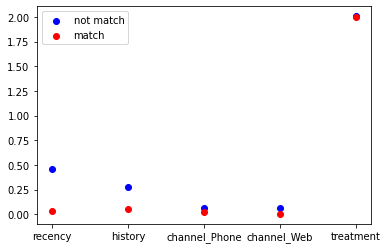

In [39]:
import matplotlib.pyplot as plt

k = (df.query('treatment == 1').mean() - df.query('treatment == 0').mean()) / df.std()
plt.scatter(k.index, k.abs(), color='blue', label='not match')

kk = match.merge(X.reset_index(), on='index', how='left')[['treatment', 'recency', 'history', 'channel_Phone', 'channel_Web']]
kkk = (kk.query('treatment == 1').mean() - kk.query('treatment == 0').mean()) / kk.std()
plt.scatter(kkk.index, kkk.abs(), color='red', label='match')

plt.legend()

## IPW

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression


biased_df = pd.read_pickle('data/biased_df.pkl')

y = biased_df['treatment']
X = pd.get_dummies(biased_df[['recency', 'channel', 'history']], columns=['channel'], drop_first=True)

lr = LogisticRegression(random_state=42)
lr.fit(X, y)
ps_score = lr.predict_proba(X)[:, 1]

In [3]:
weight_0 = 1 / (1 - ps_score[y[y == 0].index])
weight_1 = 1 / ps_score[y[y == 1].index]

In [4]:
z_ps = pd.DataFrame({'treatment': y, 'ps_score': ps_score})
z_ps['weight'] = (1 - z_ps['treatment']) / (1 - z_ps['ps_score']) + z_ps['treatment'] / z_ps['ps_score']

In [5]:
z_ps['spend'] = biased_df['spend']
z_ps

,treatment,ps_score,weight,spend
0,0,0.510585,2.043256,0.0
1,0,0.525221,2.106244,0.0
2,0,0.912623,11.444681,0.0
3,0,0.721723,3.593544,0.0
4,0,0.524183,2.101648,0.0
...,...,...,...,...
31920,1,0.316614,3.158424,0.0
31921,1,0.510165,1.960150,0.0
31922,1,0.349279,2.863037,0.0
31923,1,0.361109,2.769248,0.0


In [25]:
z1 = z_ps.query('treatment == 1')
z0 = z_ps.query('treatment == 0')

print((z1['spend'] * z1['weight']).sum() / z1['weight'].sum())
print((z0['spend'] * z0['weight']).sum() / z0['weight'].sum())

1.4758746142116805
0.5902908912501398


In [27]:
1.4758746142116805 - 0.5902908912501398

0.8855837229615408

In [28]:
import statsmodels.api as sm

y = biased_df['spend']
x = sm.add_constant(z_ps['treatment'])
results = sm.WLS(y, x, weights=z_ps['weight']).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     27.07
Date:                Tue, 04 Aug 2020   Prob (F-statistic):           1.97e-07
Time:                        12:34:27   Log-Likelihood:            -1.3278e+05
No. Observations:               31925   AIC:                         2.656e+05
Df Residuals:                   31923   BIC:                         2.656e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5903      0.120      4.920      0.000       0.355       0.825
treatment      0.8856      0.170      5.203      0.000       0.552       1.219
==============================================================================
Omnibus:                    71708.008   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        414882195.972
Skew:                          21.418   Prob(JB):                         0.00
Kurtosis:                     559.828   Cond. No.                         2.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
d = pd.DataFrame()
for col in X.columns:
    d[col] = X[col] * z_ps['weight']

In [16]:
d['treatment'] = y

In [17]:
d

,recency,history,channel_Phone,channel_Web,treatment
0,16.346046,1170.070410,0.000000,2.043256,0
1,10.531220,89.262618,2.106244,0.000000,0
2,11.444681,34373.870657,11.444681,0.000000,0
3,3.593544,2379.285260,0.000000,3.593544,0
4,10.508238,93.250103,0.000000,2.101648,0
...,...,...,...,...,...
31920,37.901087,94.721134,0.000000,3.158424,1
31921,11.760901,306.508687,0.000000,1.960150,1
31922,31.493408,179.111602,2.863037,0.000000,1
31923,30.461729,414.584125,2.769248,0.000000,1


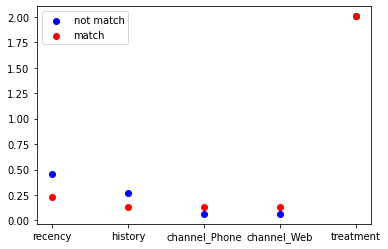

In [20]:
import matplotlib.pyplot as plt

k = (df.query('treatment == 1').mean() - df.query('treatment == 0').mean()) / df.std()
plt.scatter(k.index, k.abs(), color='blue', label='not match')

kkk = (d.query('treatment == 1').mean() - d.query('treatment == 0').mean()) / d.std()
plt.scatter(kkk.index, kkk.abs(), color='red', label='match')

plt.legend()